In [1]:
from collections import namedtuple

import jax
import jax.numpy as jnp
import numpy as np

from vorpy.symplectic_integration.nonseparable_hamiltonian import integrate, heuristic_estimate_for_omega
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from cgc.graph import ComputationalGraph, derivative
from cgc.types import LearnableParameter, ConstantParameter


In [2]:
def get_hamiltonian_from(graph: ComputationalGraph, Z):
    """Retunr a callable for the learned hamiltonina from CGC."""
    H_fn = graph._unknown_functions["H"]
    return lambda pq: H_fn._f(pq, H_fn.parameter(Z), H_fn.observation(Z))


In [3]:
def hamiltonian_symplectic_int(H_grad, initial_conditions, t, order=2, c=10):
    """Symplectically integerate a hamiltonina system."""
    dt = jnp.mean(jnp.diff(t))
    omega = heuristic_estimate_for_omega(delta=dt, order=order, c=c)
    dim = int(len(initial_conditions) / 2)

    dH_dp = lambda q, p: H_grad(jnp.hstack((p, q)))[:dim]
    dH_dq = lambda q, p: H_grad(jnp.hstack((p, q)))[dim:]

    init_conds = jnp.asarray(initial_conditions).reshape((2, -1))[::-1]

    return integrate(
        initial_coordinates=init_conds,
        t_v=t,
        dH_dp=dH_dp,
        dH_dq=dH_dq,
        order=order,
        omega=omega
    )

# Mass-Spring System

## Data Generation

In [13]:
def ms_system_ode(pq, t):
    p, q = pq
    h_grad = [
        -q,
        p
    ]

    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(ms_system_ode, [-0.1, -0.1], t)

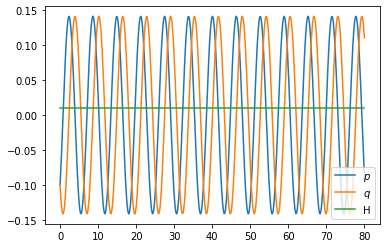

In [14]:
p, q = pq.T
H = 0.5 * (p ** 2 + q ** 2)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [6]:
OBSERVATIONS_END = 200

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[OBSERVATIONS_END:, 1:3] = False
M[:, 3] = False

X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]
X[:, 3] = 0.1

In [7]:
ms_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

ms_graph.add_observable("t")
ms_graph.add_unknown_fn("t", "q", alpha=0.01, gamma=LearnableParameter(1.2))
ms_graph.add_unknown_fn("t", "p", alpha=0.01, gamma=LearnableParameter(1.2))

ms_graph.add_known_fn("p", "p_dot", derivative)
ms_graph.add_known_fn("q", "q_dot", derivative)
ms_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

ms_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

ms_graph.add_aggregator(["p", "q"], "pq")
ms_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, gamma=1.0)
ms_graph.add_known_fn("H", "grad_H", derivative)

ms_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
ms_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

ms_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
ms_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [8]:
ms_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [9]:
Z = ms_graph.complete(X, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=5)

Loss: 0.0535:   0%|          | 6/10000 [00:17<8:14:59,  2.97s/it] 


{'q': 1.3004727363586426, 'p': 2.1571195125579834, 'H': 1.0}


Loss: 0.0674:   0%|          | 3/10000 [00:17<15:55:59,  5.74s/it]


{'q': 1.412258267402649, 'p': 2.131889820098877, 'H': 1.0}


Loss: 0.0713:   0%|          | 3/10000 [00:18<16:49:26,  6.06s/it]


{'q': 1.488723635673523, 'p': 2.1397640705108643, 'H': 1.0}


Loss: 0.0731:   0%|          | 7/10000 [00:17<6:54:41,  2.49s/it] 


{'q': 2.055121898651123, 'p': 2.138416290283203, 'H': 1.0}


Loss: 0.0837:   0%|          | 4/10000 [00:17<12:23:02,  4.46s/it]


{'q': 2.197331190109253, 'p': 2.131545305252075, 'H': 1.0}


Loss: 0.0837:   0%|          | 5/10000 [00:19<10:37:41,  3.83s/it]


{'q': 2.1877734661102295, 'p': 2.114971160888672, 'H': 1.0}


Loss: 7.6365:   0%|          | 13/10000 [00:18<3:59:43,  1.44s/it]


In [10]:
ms_graph.report_kernel_params()

{'q': 1.412258267402649, 'p': 2.131889820098877, 'H': 1.0}


## CGC Extrapolation

In [11]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 0.000042768
Extrapolation MSE on Q = 0.000043120


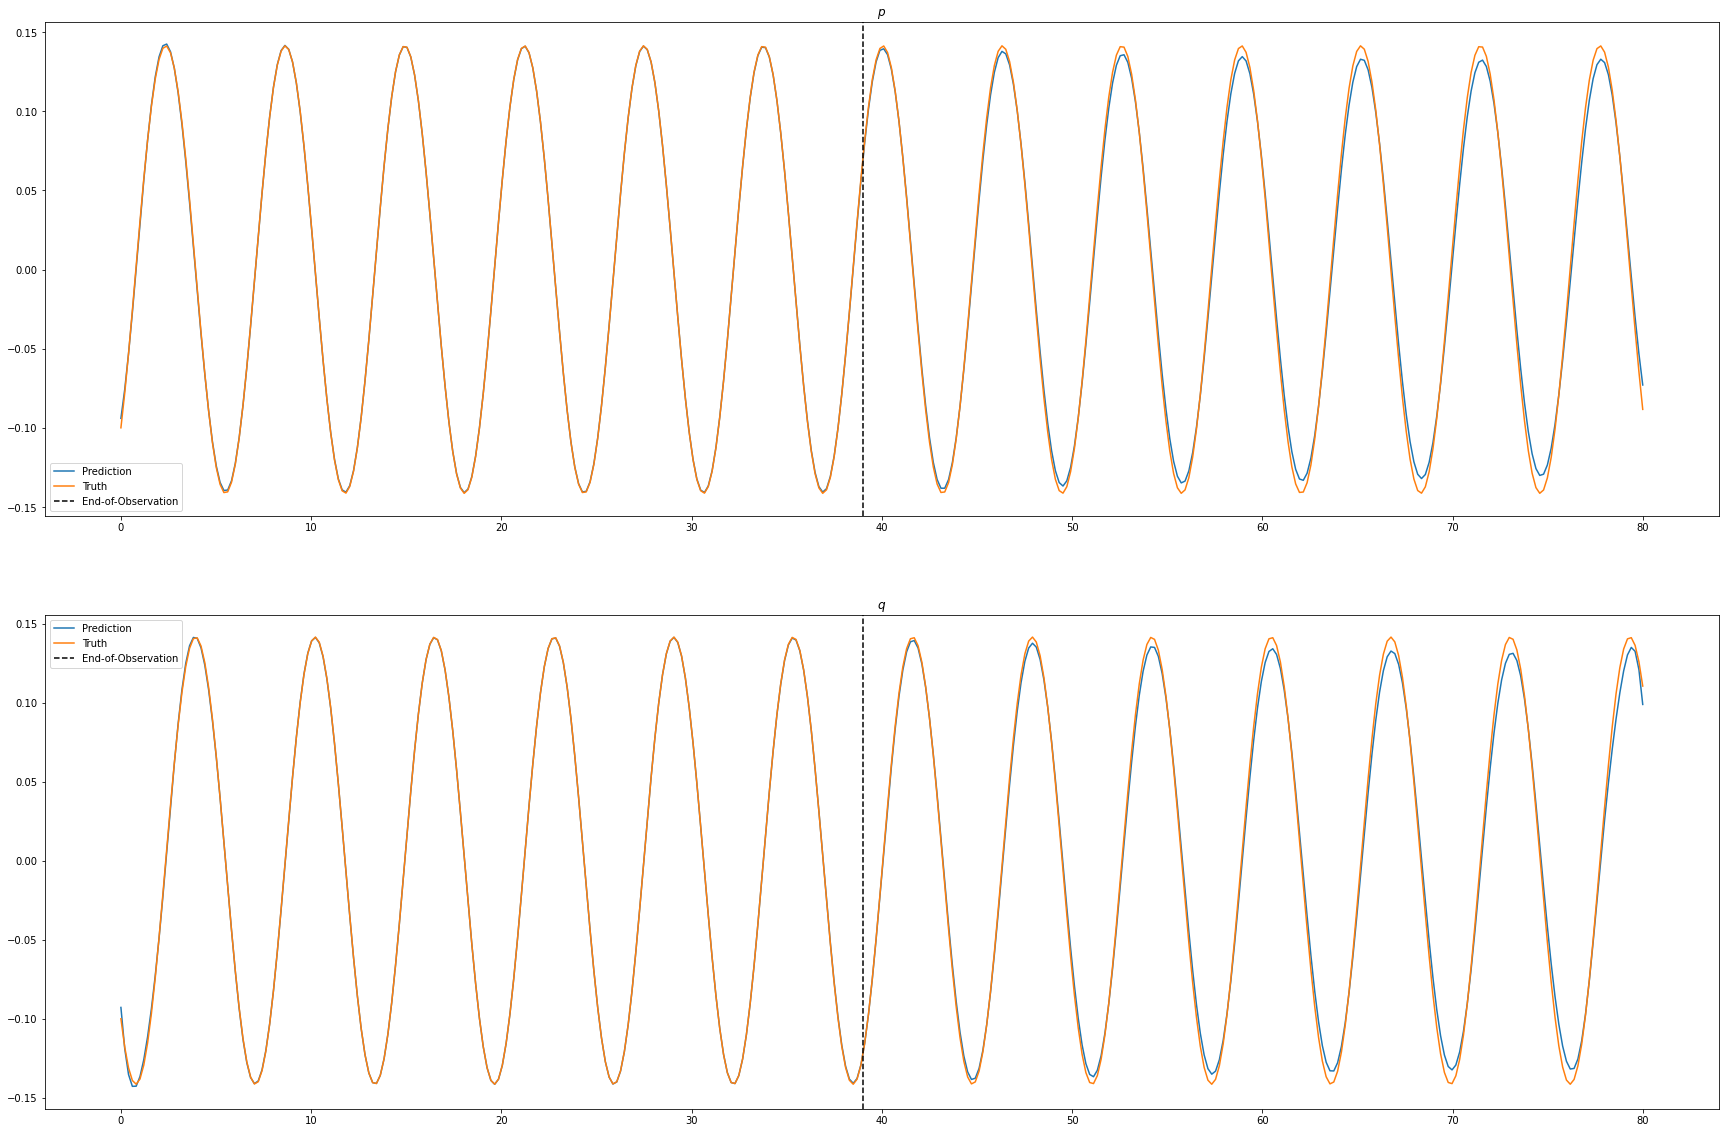

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()

## Symplectic Integeration Extrapolation

In [13]:
H_ms_est = get_hamiltonian_from(ms_graph, Z[:200])
H_ms_est_grad = jax.jit(jax.grad(H_ms_est))

t = np.linspace(0, 80, 400)
pq_symplectic = hamiltonian_symplectic_int(H_ms_est_grad, [-0.1, -0.1], t)
pq_symplectic = jnp.squeeze(pq_symplectic)

In [14]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 0.000075761
Extrapolation MSE on Q = 0.000071653


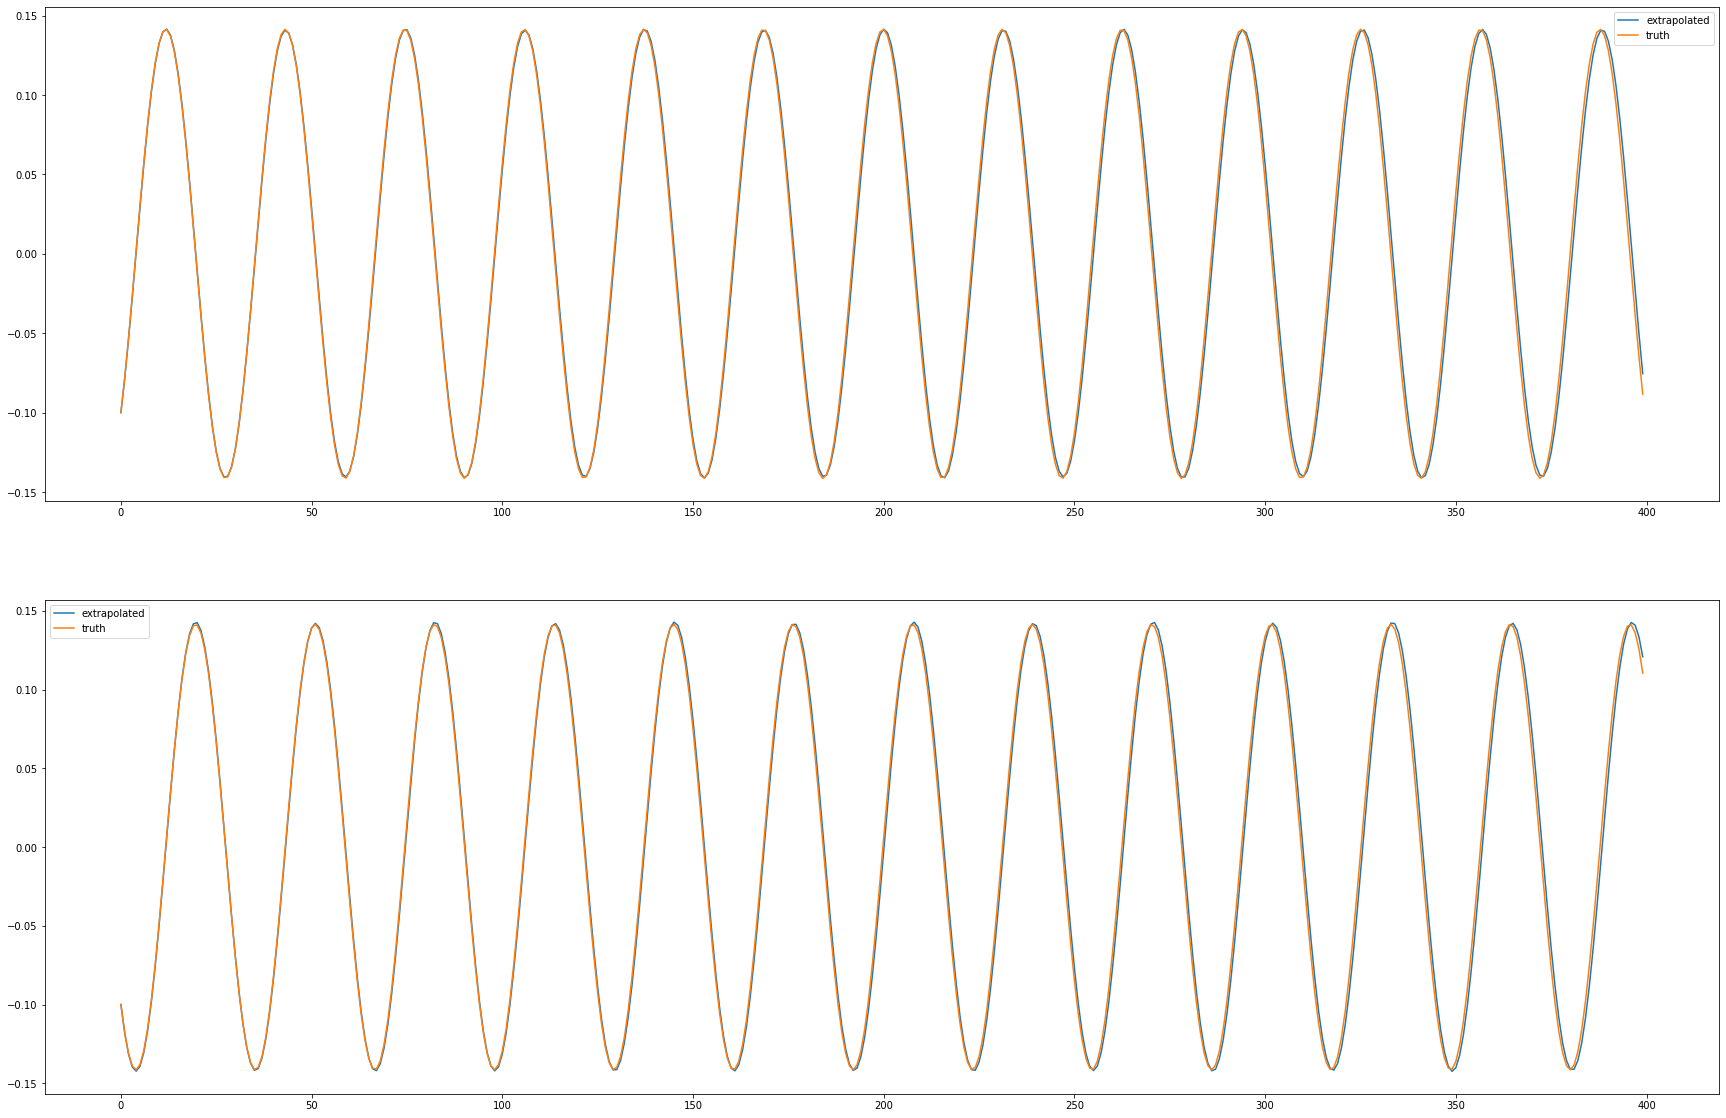

In [15]:
_, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(pq_symplectic[:, 1], label="extrapolated")
axes[0].plot(p, label="truth")
axes[0].legend()
axes[1].plot(pq_symplectic[:, 0], label="extrapolated")
axes[1].plot(q, label="truth")
axes[1].legend()

# Two-Mass-Three-Springs System

## Data Generation

In [4]:
def m2s3_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 + (q2 - q1),
        -q2 - (q2 - q1),
        p1,
        p2
    ]
    
    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(m2s3_system_ode, [0.1, -0.1, 0.2, -0.1], t)

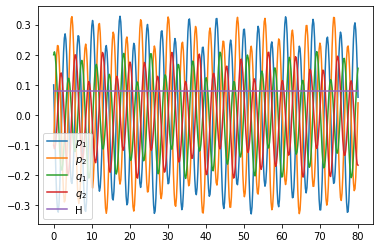

In [5]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + (q2 - q1) ** 2 + p1 ** 2 + p2 ** 2)

plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [6]:
OBSERVATIONS_END = 200

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[OBSERVATIONS_END:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [7]:
m2s3_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

m2s3_graph.add_observable("t")
m2s3_graph.add_unknown_fn("t", "p1", alpha=0.01, gamma=LearnableParameter(1.5))
m2s3_graph.add_unknown_fn("t", "p2", alpha=0.01, gamma=LearnableParameter(1.5))
m2s3_graph.add_unknown_fn("t", "q1", alpha=0.01, gamma=LearnableParameter(1.5))
m2s3_graph.add_unknown_fn("t", "q2", alpha=0.01, gamma=LearnableParameter(1.5))

m2s3_graph.add_known_fn("p1", "p1_dot", derivative)
m2s3_graph.add_known_fn("p2", "p2_dot", derivative)
m2s3_graph.add_known_fn("q1", "q1_dot", derivative)
m2s3_graph.add_known_fn("q2", "q2_dot", derivative)

m2s3_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
m2s3_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
m2s3_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

m2s3_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
m2s3_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, gamma=1)
m2s3_graph.add_known_fn("H", "grad_H", derivative)

m2s3_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

m2s3_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

m2s3_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
m2s3_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [8]:
m2s3_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [9]:
Z = m2s3_graph.complete(X, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=5)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss: 0.0200:   0%|          | 569/500000 [00:48<11:44:29, 11.82it/s]


Stopped after 50 steps with no improvment in Loss
p1: 0.9759770035743713


Loss: 0.0173:   0%|          | 670/500000 [00:49<10:19:04, 13.44it/s]


Stopped after 50 steps with no improvment in Loss
p2: 0.8649784326553345


Loss: 0.0229:   0%|          | 792/500000 [00:54<9:35:37, 14.45it/s] 


Stopped after 50 steps with no improvment in Loss
q1: 0.7509799003601074


Loss: 0.0246:   0%|          | 778/500000 [00:50<9:04:50, 15.27it/s] 


Stopped after 50 steps with no improvment in Loss
q2: 0.7649797201156616


Loss: 0.0294:   0%|          | 307/500000 [00:04<1:59:14, 69.85it/s]


Stopped after 50 steps with no improvment in Loss
p1: 1.237987756729126


Loss: 0.0270:   0%|          | 330/500000 [00:04<2:02:31, 67.96it/s]


Stopped after 50 steps with no improvment in Loss
p2: 1.1539838314056396


Loss: 0.0317:   0%|          | 148/500000 [00:02<2:09:45, 64.20it/s]


Stopped after 50 steps with no improvment in Loss
q1: 0.6519811749458313


Loss: 0.0390:   0%|          | 215/500000 [00:03<2:07:45, 65.20it/s]


Stopped after 50 steps with no improvment in Loss
q2: 0.5989818572998047


Loss: 0.0237:   0%|          | 324/500000 [00:04<2:01:19, 68.64it/s]


Stopped after 50 steps with no improvment in Loss
p1: 0.9609771966934204


Loss: 0.0211:   0%|          | 338/500000 [00:04<1:57:13, 71.04it/s]


Stopped after 50 steps with no improvment in Loss
p2: 0.862978458404541


Loss: 0.0233:   0%|          | 461/500000 [00:06<1:59:51, 69.46it/s]


Stopped after 50 steps with no improvment in Loss
q1: 1.0679798126220703


Loss: 0.0251:   0%|          | 557/500000 [00:08<2:02:00, 68.23it/s]


Stopped after 50 steps with no improvment in Loss
q2: 1.112981915473938


Loss: 0.0298:   0%|          | 328/500000 [00:04<2:03:15, 67.57it/s]


Stopped after 50 steps with no improvment in Loss
p1: 1.243988037109375


Loss: 0.0284:   0%|          | 367/500000 [00:05<2:03:23, 67.49it/s]


Stopped after 50 steps with no improvment in Loss
p2: 1.1809850931167603


Loss: 0.0295:   0%|          | 442/500000 [00:06<2:03:31, 67.40it/s]


Stopped after 50 steps with no improvment in Loss
q1: 0.6709809303283691


Loss: 0.0328:   0%|          | 489/500000 [00:07<2:00:29, 69.09it/s]


Stopped after 50 steps with no improvment in Loss
q2: 0.6689809560775757


Loss: 0.0237:   0%|          | 318/500000 [00:05<2:34:27, 53.92it/s]


Stopped after 50 steps with no improvment in Loss
p1: 0.9629771709442139


Loss: 0.0206:   0%|          | 362/500000 [00:06<2:31:21, 55.02it/s]


Stopped after 50 steps with no improvment in Loss
p2: 0.8679783940315247


Loss: 0.0244:   0%|          | 455/500000 [00:08<2:34:42, 53.82it/s]


Stopped after 50 steps with no improvment in Loss
q1: 1.0849806070327759


Loss: 0.0297:   0%|          | 548/500000 [00:09<2:30:48, 55.20it/s]


Stopped after 50 steps with no improvment in Loss
q2: 1.1779849529266357


In [10]:
m2s3_graph.report_kernel_params()

{'p1': 0.9759770035743713, 'p2': 0.8649784326553345, 'q1': 0.7509799003601074, 'q2': 0.7649797201156616, 'H': 1.0}


## CGC Extrapolation

In [11]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 3]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 4]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.006208537
Extrapolation MSE on Q1 = 0.002119994
Extrapolation MSE on P2 = 0.005835258
Extrapolation MSE on Q2 = 0.001868224


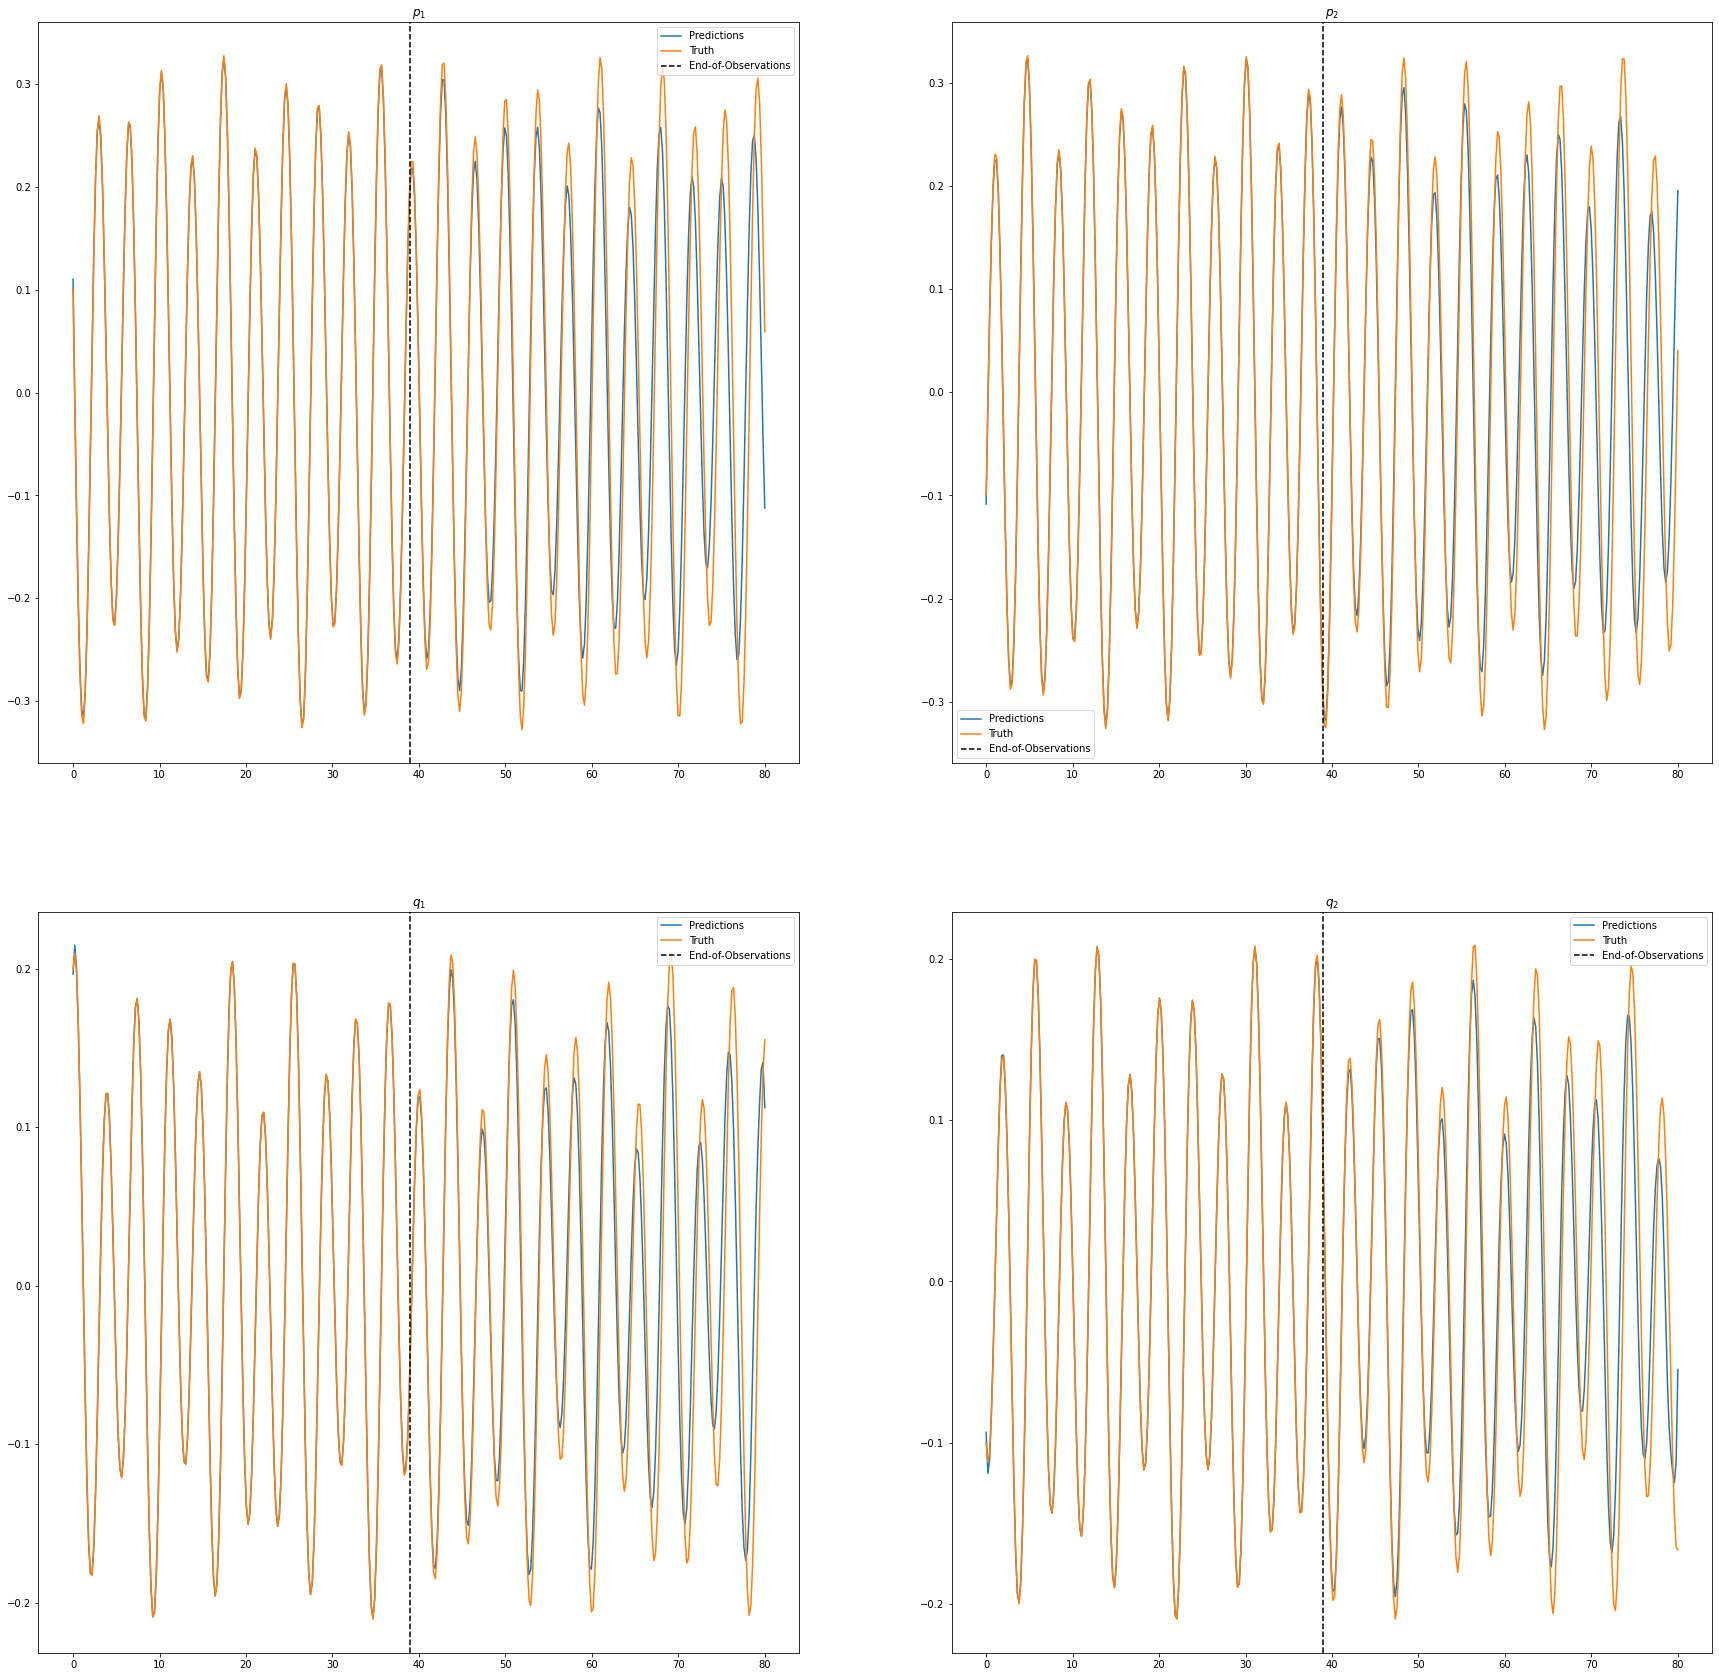

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

## Symplectic Integeration Extrapolation

In [13]:
H_m2s3_est = get_hamiltonian_from(m2s3_graph, Z[:200, :])
H_m2s3_est_grad = jax.jit(jax.grad(H_m2s3_est))

pq_symplectic = hamiltonian_symplectic_int(H_m2s3_est_grad, [0.1, -0.1, 0.2, -0.1], t)
pq_symplectic = jnp.squeeze(pq_symplectic)

In [14]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1, 0]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0, 0]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1, 1]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0, 1]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.003857767
Extrapolation MSE on Q1 = 0.001298254
Extrapolation MSE on P2 = 0.003875742
Extrapolation MSE on Q2 = 0.001317170


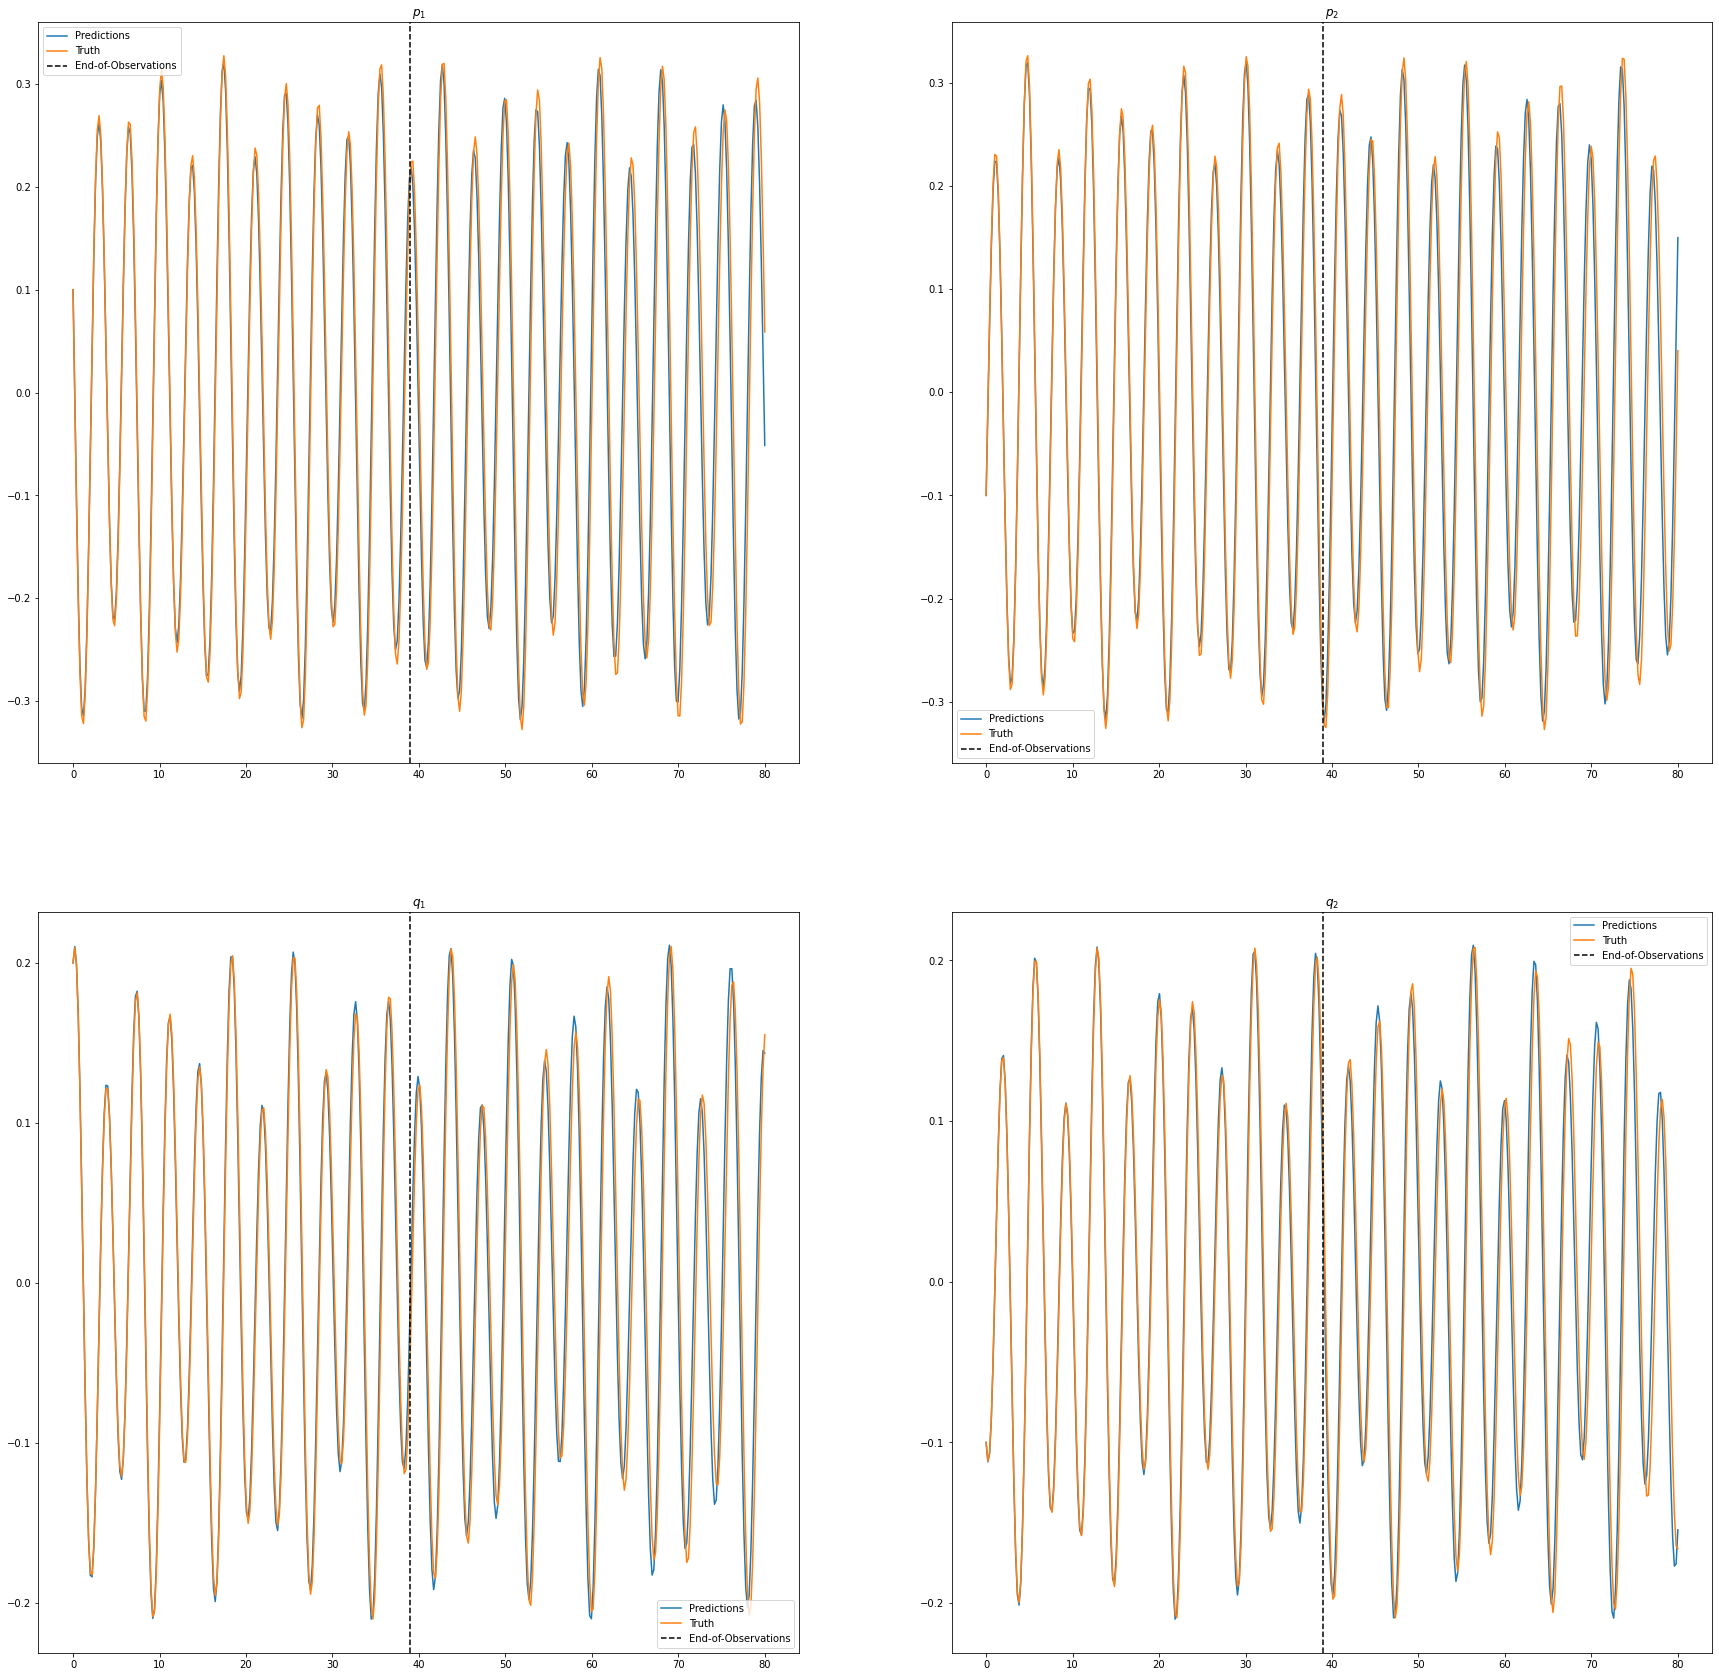

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "est", "truth", "label"])

plots_data = [
    PlotData((0, 0), pq_symplectic[:, 1, 0], p1, "$p_1$"),
    PlotData((0, 1), pq_symplectic[:, 1, 1], p2, "$p_2$"),
    PlotData((1, 0), pq_symplectic[:, 0, 0], q1, "$q_1$"),
    PlotData((1, 1), pq_symplectic[:, 0, 1], q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, data.est, label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

# Hénon–Heiles System

## Data Generation

In [4]:
def hh_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 - 2 * q1 * q2,
        -q2 - q1 ** 2 + q2 ** 2,
        p1,
        p2
    ]

    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(hh_system_ode, [0.1, -0.1, 0.2, -0.1], t)


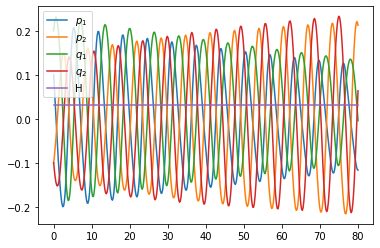

In [5]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + p1 ** 2 + p2 ** 2) + q2 * q1 ** 2 - (1/3) * q2 ** 3

plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [6]:
OBSERVATIONS_END = 200

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[OBSERVATIONS_END:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [7]:
hh_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

hh_graph.add_observable("t")
hh_graph.add_unknown_fn("t", "p1", alpha=0.01, gamma=LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "p2", alpha=0.01, gamma=LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "q1", alpha=0.01, gamma=LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "q2", alpha=0.01, gamma=LearnableParameter(1.2))

hh_graph.add_known_fn("p1", "p1_dot", derivative)
hh_graph.add_known_fn("p2", "p2_dot", derivative)
hh_graph.add_known_fn("q1", "q1_dot", derivative)
hh_graph.add_known_fn("q2", "q2_dot", derivative)

hh_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
hh_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
hh_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

hh_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
hh_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

hh_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, gamma=LearnableParameter(1.0), kernel="cubic+rbf")
hh_graph.add_known_fn("H", "grad_H", derivative)

hh_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

hh_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

hh_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
hh_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [8]:
#hh_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [9]:
Z = hh_graph.complete(X, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss: 0.2161:   0%|          | 23/10000 [00:52<6:21:26,  2.29s/it] 


{'p1': 1.1643805503845215, 'p2': 1.0984331369400024, 'q1': 1.476791501045227, 'q2': 1.5031408071517944, 'H': 2.013155937194824}


Loss: 0.2492:   0%|          | 7/10000 [00:54<21:26:48,  7.73s/it] 


{'p1': 1.19704008102417, 'p2': 1.1037555932998657, 'q1': 1.5605661869049072, 'q2': 1.6961101293563843, 'H': 2.0117595195770264}


Loss: 6.8298:   0%|          | 14/10000 [00:46<9:13:57,  3.33s/it] 


In [10]:
hh_graph.report_kernel_params()

{'p1': 1.1643805503845215, 'p2': 1.0984331369400024, 'q1': 1.476791501045227, 'q2': 1.5031408071517944, 'H': 2.013155937194824}


In [11]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 3]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 4]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.000955984
Extrapolation MSE on Q1 = 0.001188723
Extrapolation MSE on P2 = 0.000347558
Extrapolation MSE on Q2 = 0.000367052


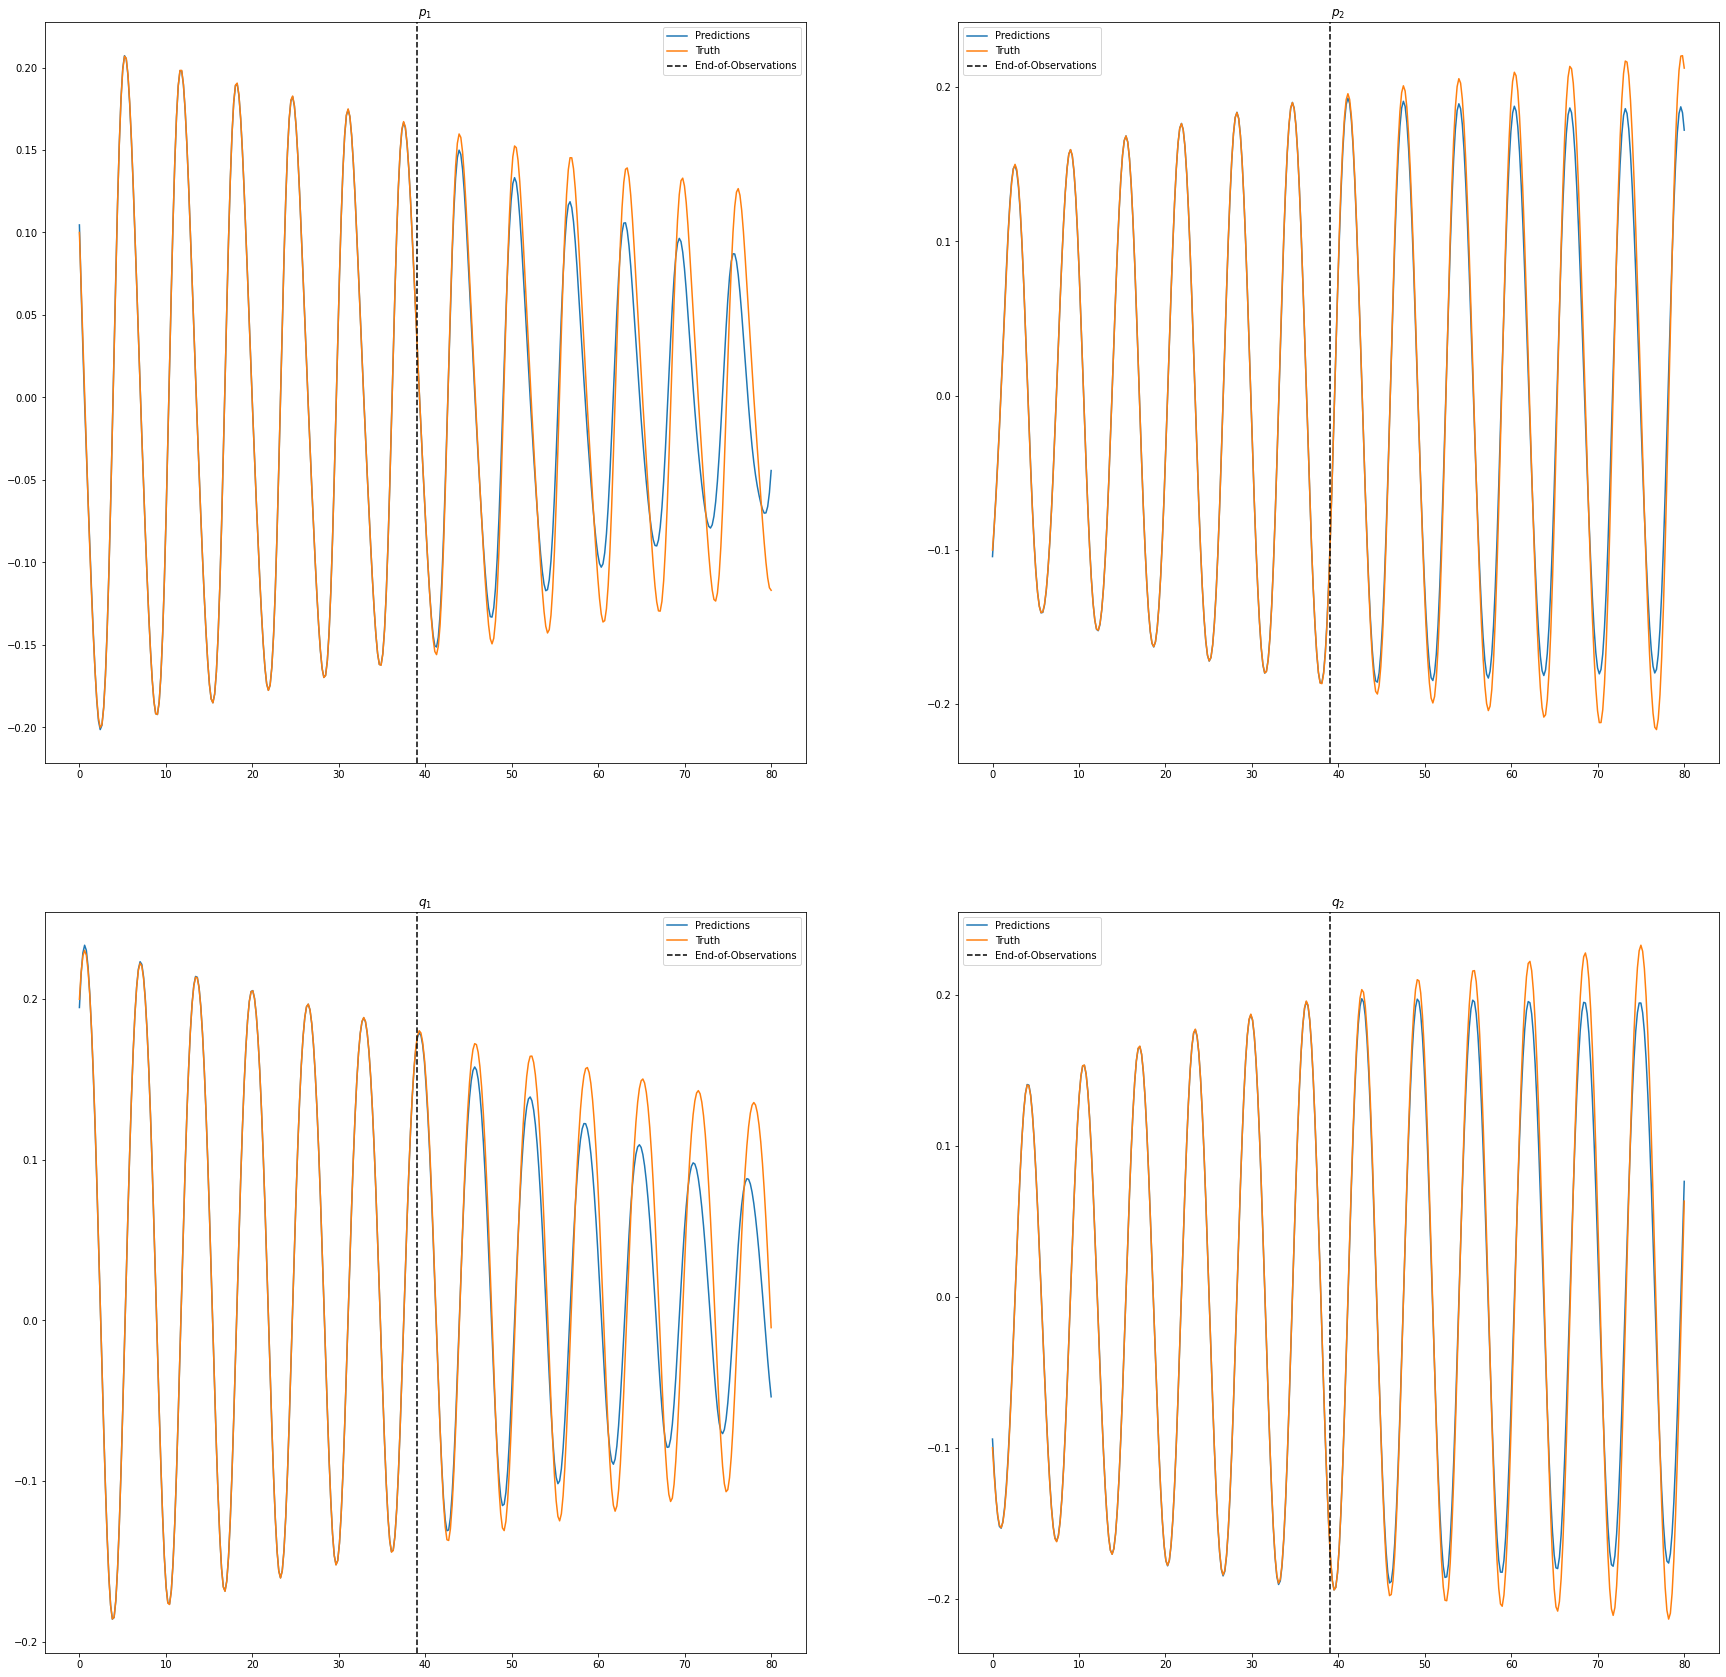

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

In [13]:
H_hh_est = get_hamiltonian_from(hh_graph, Z[:200])
H_hh_est_grad = jax.jit(jax.grad(H_hh_est))

pq_symplectic = hamiltonian_symplectic_int(H_hh_est_grad, [0.1, -0.1, 0.2, -0.1], t, order=2)
pq_symplectic = jnp.squeeze(pq_symplectic)

In [14]:
mse_p1 = jnp.mean((p1[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1, 0]) ** 2)
mse_q1 = jnp.mean((q1[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0, 0]) ** 2)
mse_p2 = jnp.mean((p2[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1, 1]) ** 2)
mse_q2 = jnp.mean((q2[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0, 1]) ** 2)

print(f"Extrapolation MSE on P1 = {mse_p1:.9f}")
print(f"Extrapolation MSE on Q1 = {mse_q1:.9f}")
print(f"Extrapolation MSE on P2 = {mse_p2:.9f}")
print(f"Extrapolation MSE on Q2 = {mse_q2:.9f}")

Extrapolation MSE on P1 = 0.001168217
Extrapolation MSE on Q1 = 0.001337364
Extrapolation MSE on P2 = 0.000166600
Extrapolation MSE on Q2 = 0.000185068


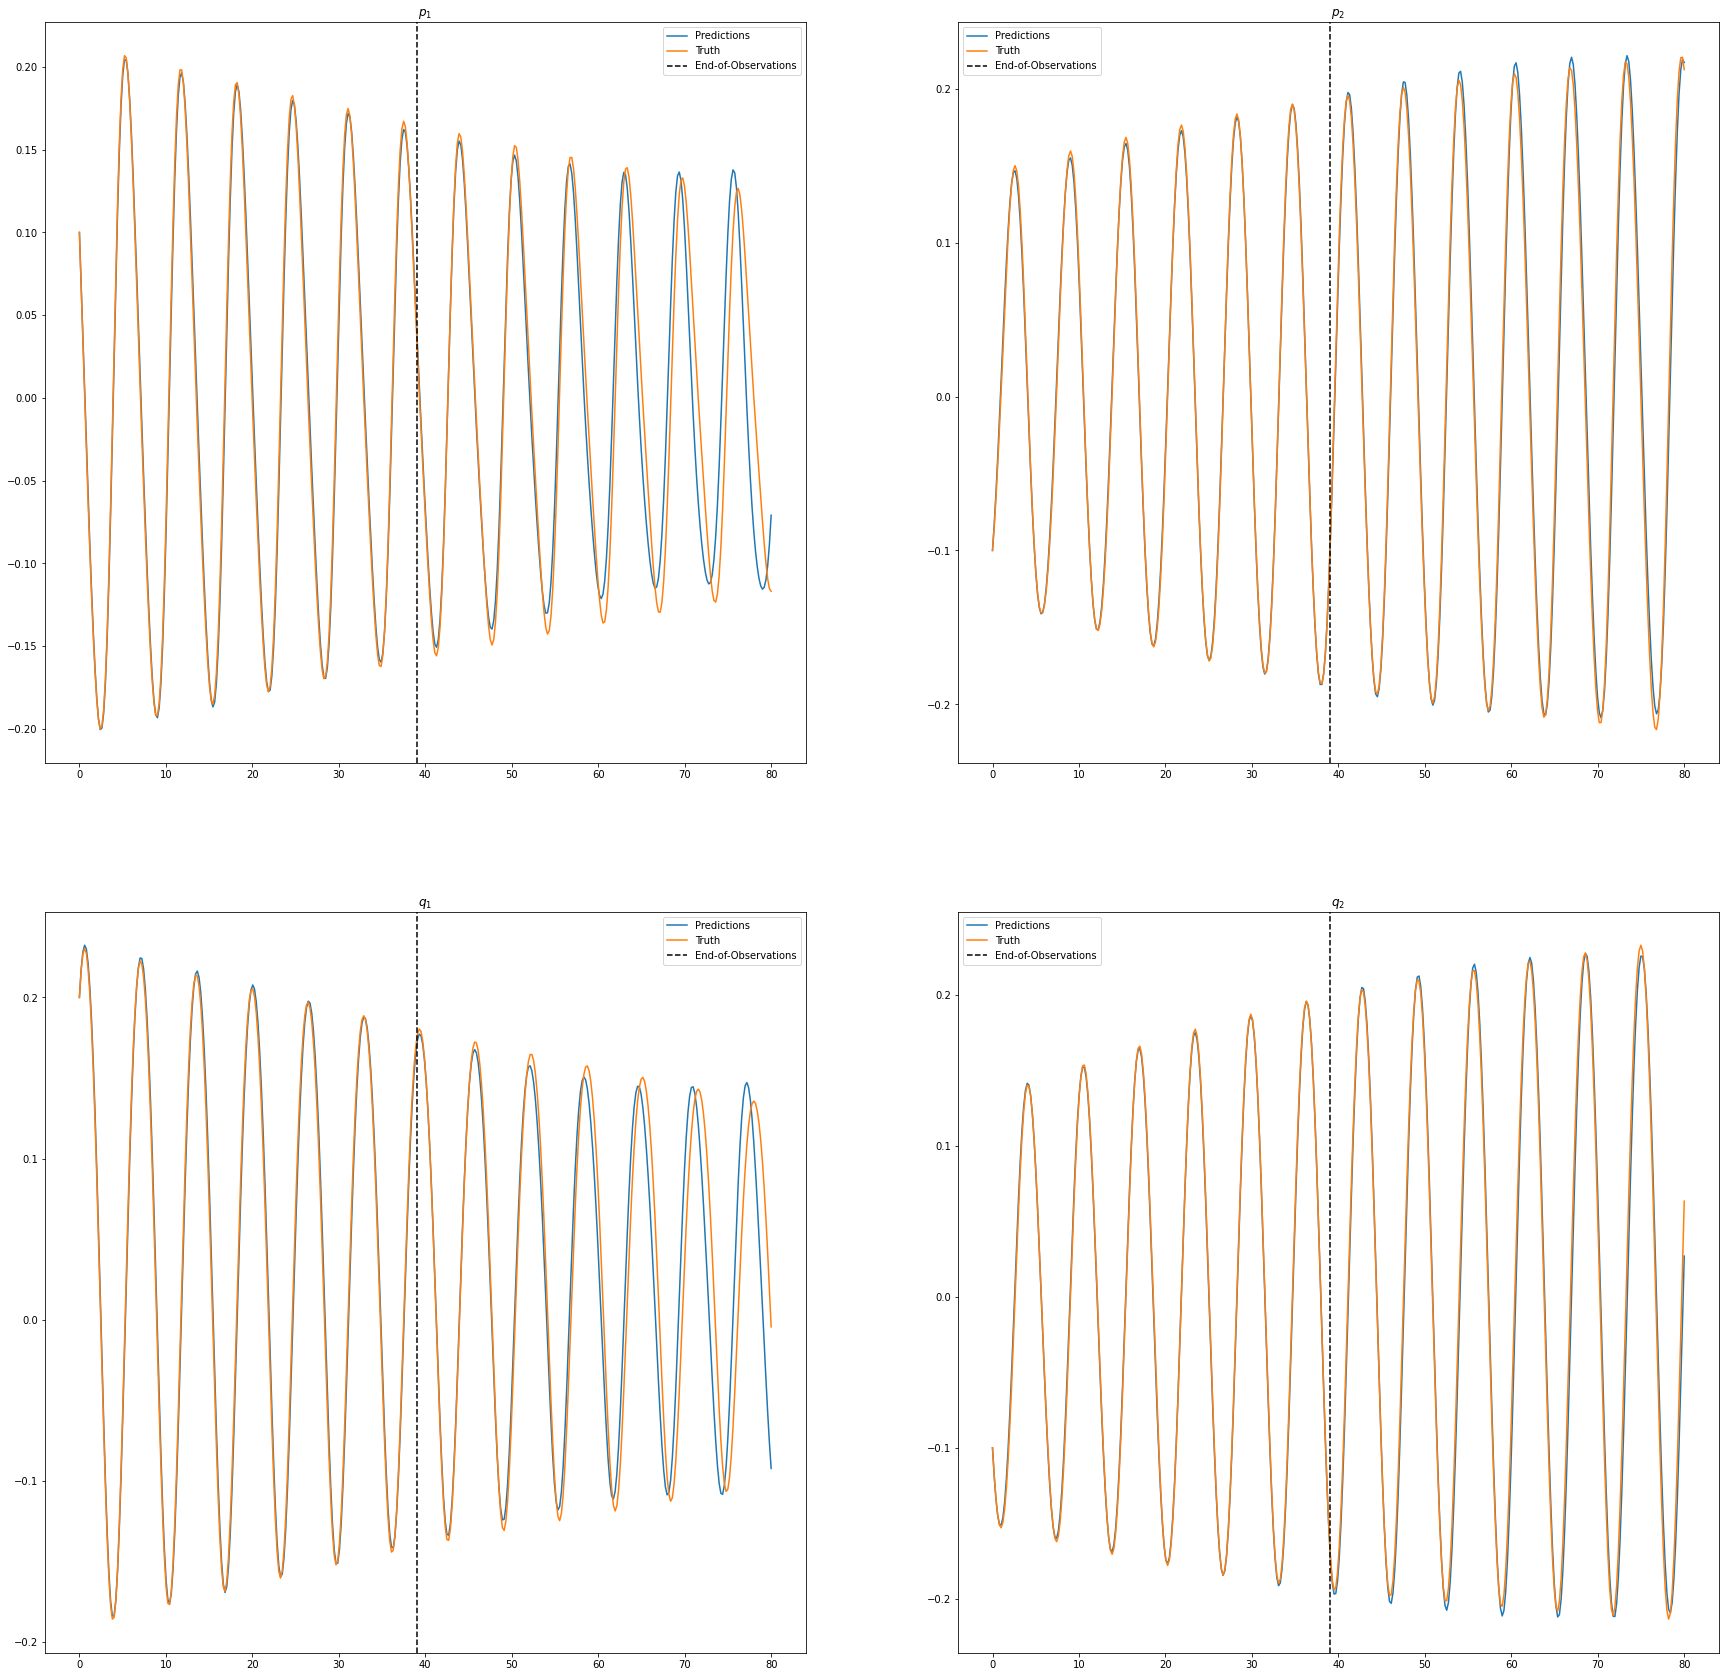

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "est", "truth", "label"])

plots_data = [
    PlotData((0, 0), pq_symplectic[:, 1, 0], p1, "$p_1$"),
    PlotData((0, 1), pq_symplectic[:, 1, 1], p2, "$p_2$"),
    PlotData((1, 0), pq_symplectic[:, 0, 0], q1, "$q_1$"),
    PlotData((1, 1), pq_symplectic[:, 0, 1], q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, data.est, label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

# Nonliner Pendulum

## Data Generation

In [46]:
import jax
import jax.numpy as jnp
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt

def H(p, q):
    return (0.5 * p ** 2) - jnp.cos(q)

def dq_H(p, q):
    return np.sin(q)

def dp_H(p, q):
    return p

p_dot = lambda p, q: -1 * dq_H(p, q)
q_dot = lambda p, q: dp_H(p, q)

def system_ode(pq, t):
    h_grad = [0, 0]
    p, q = pq
    h_grad[0] = p_dot(p, q)
    h_grad[1] = q_dot(p, q)
    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(system_ode, [0.1, 0.1], t=t)

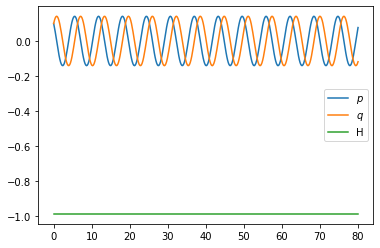

In [47]:
p, q = pq.T
H = H(p, q)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [48]:
OBSERVATIONS_END = 200

X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[200:, 1:3] = False
M[:, 3] = False

X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]

In [49]:
np_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

np_graph.add_observable("t")
np_graph.add_unknown_fn("t", "p", alpha=0.01, gamma=LearnableParameter(1.0))
np_graph.add_unknown_fn("t", "q", alpha=0.01, gamma=LearnableParameter(1.0))

np_graph.add_known_fn("p", "p_dot", derivative)
np_graph.add_known_fn("q", "q_dot", derivative)
np_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

np_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

np_graph.add_aggregator(["p", "q"], "pq")
np_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, gamma=1.0)
np_graph.add_known_fn("H", "grad_H", derivative)

np_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
np_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

np_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
np_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [50]:
np_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [52]:
Z = np_graph.complete(X, M, OBSERVATIONS_END, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=5)

Loss: 0.0146:   0%|          | 1057/500000 [00:58<7:38:04, 18.15it/s]


Stopped after 50 steps with no improvment in Loss
p: 2.022045135498047


Loss: 0.0170:   0%|          | 339/500000 [00:47<19:15:15,  7.21it/s]


Stopped after 50 steps with no improvment in Loss
q: 0.7040038108825684


Loss: 0.0077:   0%|          | 463/500000 [00:06<2:04:20, 66.96it/s]


Stopped after 50 steps with no improvment in Loss
p: 1.5960278511047363


Loss: 0.0134:   0%|          | 267/500000 [00:03<1:57:43, 70.74it/s]


Stopped after 50 steps with no improvment in Loss
q: 0.9320008754730225


Loss: 0.0093:   0%|          | 283/500000 [00:03<1:43:00, 80.85it/s]


Stopped after 50 steps with no improvment in Loss
p: 1.8480396270751953


Loss: 0.0171:   0%|          | 273/500000 [00:03<1:49:17, 76.21it/s]


Stopped after 50 steps with no improvment in Loss
q: 0.7060037851333618


Loss: 0.0087:   0%|          | 273/500000 [00:03<1:56:08, 71.71it/s]


Stopped after 50 steps with no improvment in Loss
p: 1.6040282249450684


Loss: 0.0134:   0%|          | 264/500000 [00:03<1:51:42, 74.56it/s]


Stopped after 50 steps with no improvment in Loss
q: 0.9310008883476257


Loss: 0.0093:   0%|          | 271/500000 [00:03<1:50:51, 75.14it/s]


Stopped after 50 steps with no improvment in Loss
p: 1.8460395336151123


Loss: 0.0171:   0%|          | 272/500000 [00:03<1:53:19, 73.50it/s]

Stopped after 50 steps with no improvment in Loss
q: 0.7060037851333618


In [53]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - Z[OBSERVATIONS_END:, 2]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 0.000003594
Extrapolation MSE on Q = 0.000003666


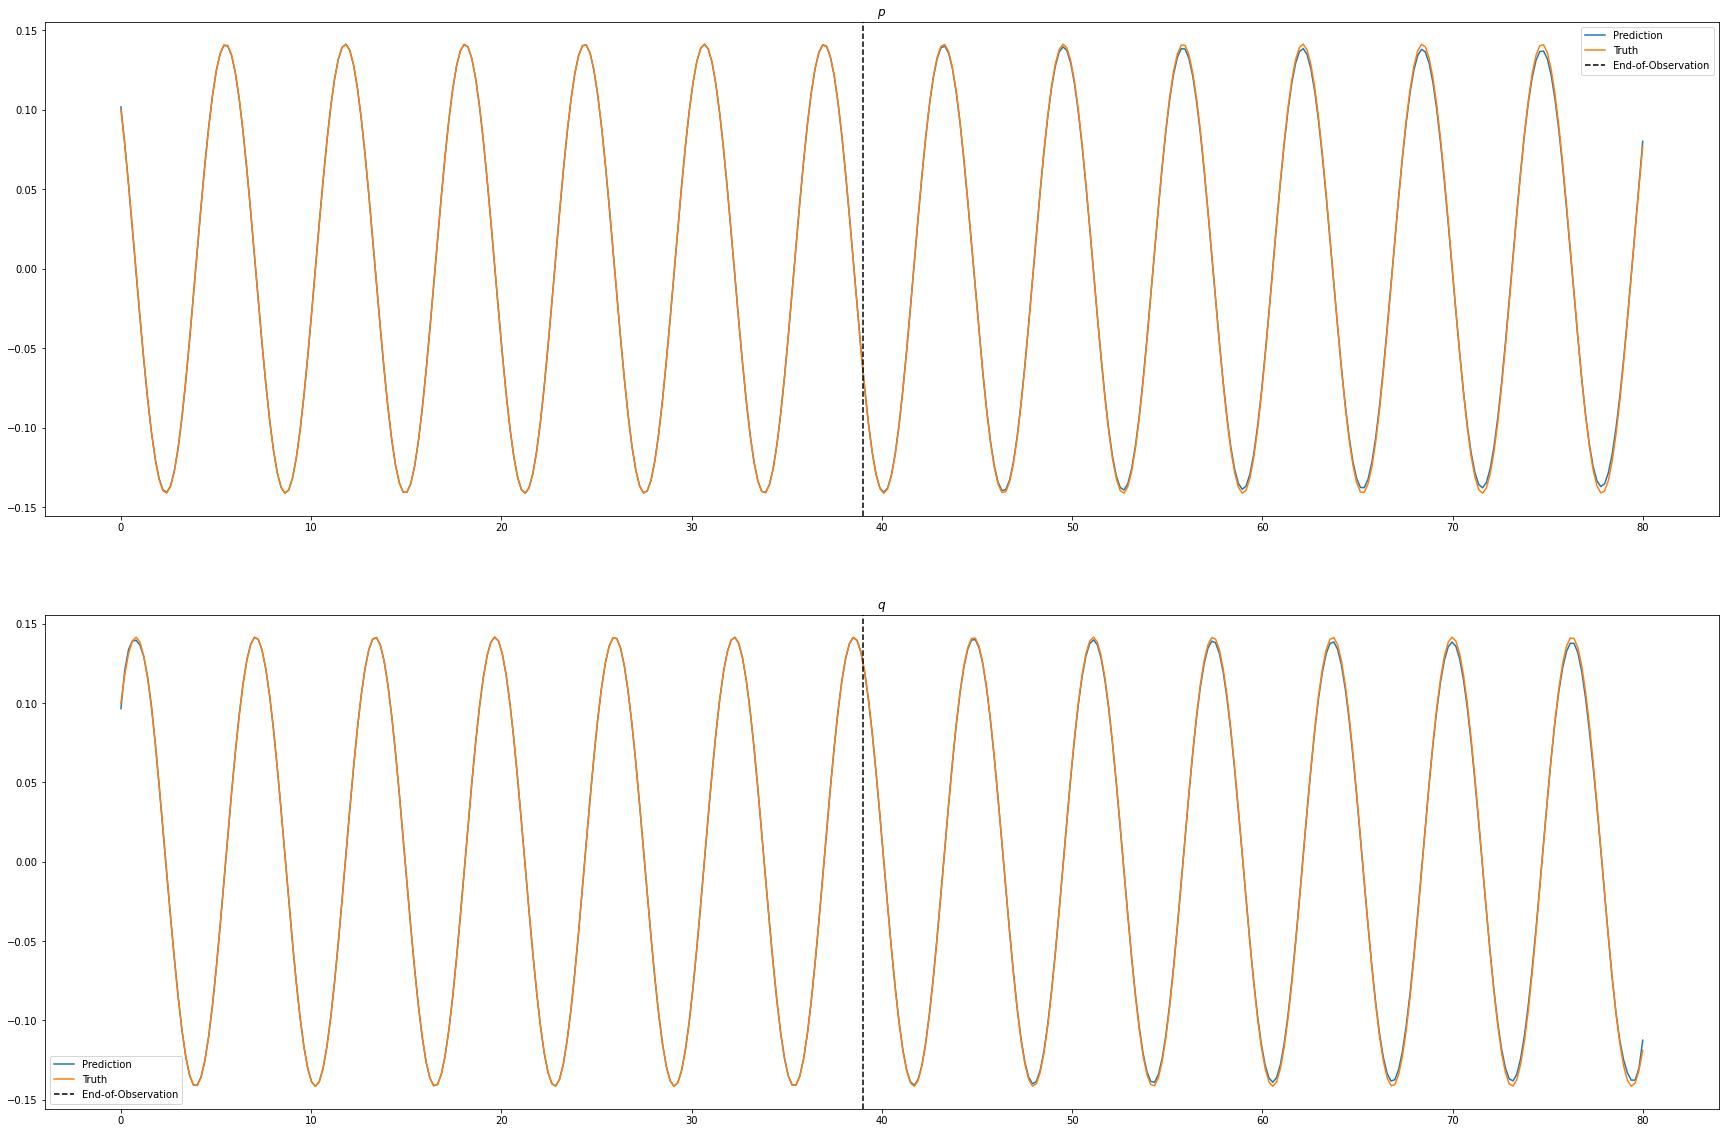

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()

In [54]:
H_np_est = get_hamiltonian_from(np_graph, Z[:200])
H_np_est_grad = jax.jit(jax.grad(H_np_est))

t = np.linspace(0, 80, 400)
pq_symplectic = hamiltonian_symplectic_int(H_np_est_grad, [0.1, 0.1], t)
pq_symplectic = jnp.squeeze(pq_symplectic)

In [55]:
mse_p = jnp.mean((p[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 1]) ** 2)
mse_q = jnp.mean((q[OBSERVATIONS_END:] - pq_symplectic[OBSERVATIONS_END:, 0]) ** 2)

print(f"Extrapolation MSE on P = {mse_p:.9f}")
print(f"Extrapolation MSE on Q = {mse_q:.9f}")

Extrapolation MSE on P = 0.000015028
Extrapolation MSE on Q = 0.000014405


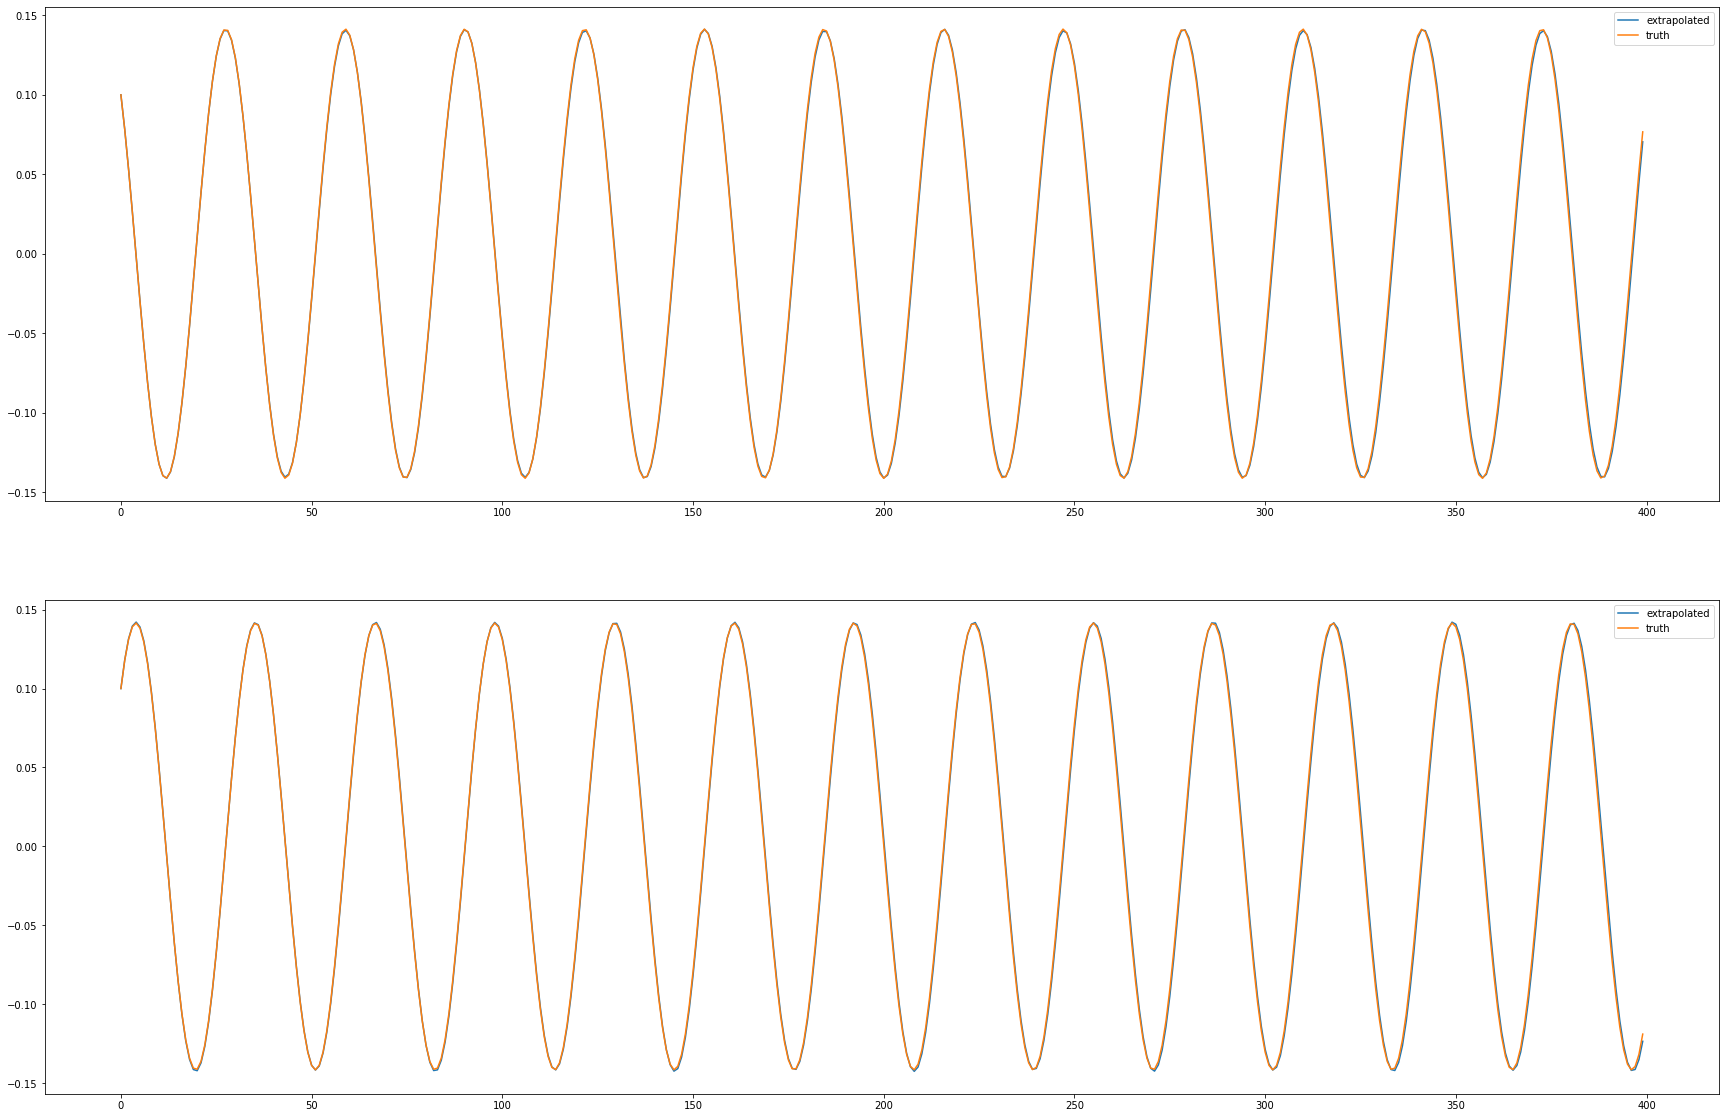

In [56]:
_, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(pq_symplectic[:, 1], label="extrapolated")
axes[0].plot(p, label="truth")
axes[0].legend()
axes[1].plot(pq_symplectic[:, 0], label="extrapolated")
axes[1].plot(q, label="truth")
axes[1].legend()